In [1]:
import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as tt
import pymc3 as pm
from sampled import sampled
import scipy.stats as st

plt.style.use('seaborn-talk')

/home/colin/miniconda3/envs/scratch3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Simulating Ecological Inference

This notebook generates some fake data that is realistic to an election where groups vote in blocs, and then shows how the ecological inference model can recover the parameters used.

Below we generate the data.  Note that the hidden values are not directly given to the model, but provided through `pct_voting_for_pete`.  We will try to infer those values.

In [2]:
# General parameters
λ = 0.5
n_precincts = 15

# Hidden
minority_pct_pete = np.random.rand(n_precincts) * 0.3 + 0.7
majority_pct_pete = np.random.rand(n_precincts) * 0.3

# Observed
pct_minority = np.random.rand(n_precincts)
pct_voting_for_pete = (pct_minority * minority_pct_pete + 
                      (1 - pct_minority) * majority_pct_pete)
voting_population = np.random.randint(100, 10000, size=n_precincts)

num_voting_for_pete = (pct_voting_for_pete * voting_population).astype(int)

# Model specification

We use `PyMC3` to define and sample from the model.

In [3]:
with pm.Model() as ecological_inference:
    α = pm.Exponential('α', lam=λ, shape=n_precincts)
    β = pm.Exponential('β', lam=λ, shape=n_precincts)
    
    est_minority_pct_pete= pm.Beta('est_minority_pct_pete', 
                                   alpha=α[0], 
                                   beta=β[0], 
                                   shape=n_precincts)
    est_majority_pct_pete = pm.Beta('est_majority_pct_pete', 
                                    alpha=α[1], 
                                    beta=β[1], 
                                    shape=n_precincts)
    
    est_pct_pete = pm.Deterministic('est_pct_pete', 
                                    pct_minority * est_minority_pct_pete + 
                                    (1 - pct_minority) * est_majority_pct_pete)

    votes_for_pete = pm.Binomial('votes_for_pete', 
                                 n=voting_population, 
                                 p=est_pct_pete, 
                                 observed=num_voting_for_pete)
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [est_majority_pct_pete_logodds__, est_minority_pct_pete_logodds__, β_log__, α_log__]
 10%|█         | 555/5500 [00:09<01:26, 57.03it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '16089' (I am process '16090')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/colin/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir
100%|██████████| 5500/5500 [01:37<00:00, 56.45it/s]
There were 355 divergences after tuning. Increase `target_accept` or reparameterize.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1123 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6511706842642012, but should be close to 0.8. Try to increase the number of tuning steps.
There w

In [4]:
def make_plot(trace, minority_pct_pete, majority_pct_pete, fig_step):
    fig, ax = plt.subplots(figsize=(16, 12))
    x = np.linspace(0, 1, 500)


    iterator = zip(
        trace['est_minority_pct_pete'].T, 
        trace['est_majority_pct_pete'].T, 
        minority_pct_pete,
        majority_pct_pete,
    )

    mult = 1.1  # controls overlap

    N = len(minority_pct_pete)

    for idx, (minority, majority, true_min, true_maj) in enumerate(iterator, 1):
        pfx = '' if idx == 1 else '_'
        precinct = 'Precinct {}'.format(idx)
        minority_kde = st.gaussian_kde(minority)
        majority_kde = st.gaussian_kde(majority)
        ax.plot([0], [precinct]);

        if fig_step > 0:
            trans = ax.convert_yunits(precinct)

            minority_y = minority_kde(x)
            true_min_y = mult * minority_kde(true_min) / minority_y.max()

            minority_y = mult * minority_y / minority_y.max()

            majority_y = majority_kde(x)
            true_maj_y = mult * majority_kde(true_maj) / majority_y.max()
            majority_y = mult * majority_y / majority_y.max()

            if fig_step > 1:
                ax.fill_between(x, minority_y + trans, trans, color='steelblue', zorder=N-idx-0.5, label=pfx + 'Minority')
            ax.fill_between(x, majority_y + trans, trans, color='salmon', zorder=N-idx, label=pfx + 'Majority')
            ax.plot(x, trans * np.ones_like(x), color='black', linewidth=4, zorder=N-idx)
            
            if fig_step > 1:
                ax.plot(x, minority_y + trans, color='black', linewidth=4, zorder=N-idx-0.5)
            ax.plot(x, majority_y + trans, color='black', linewidth=4, zorder=N-idx)
            
            if fig_step > 1:
                true_x = [true_min, true_maj]
                true_y = np.array([true_min_y, true_maj_y])
            else:
                true_x = [true_maj]
                true_y = true_maj_y
            lines = ax.vlines(true_x, trans, trans + true_y, 
                              linestyles='dashed', 
                              linewidth=4, 
                              zorder=N-idx, 
                              label=pfx + 'True Value')
        if fig_step <= 2 and idx == 1:
            break

    if fig_step <= 2:
        ax.set_xlim(0, 1)
        w, h = fig.get_size_inches()
        fig.set_size_inches(w, h / 7)
    ax.set_title('Estimated Vote for Pete')
    ax.set_xlabel('Pct vote for Pete')
    ax.legend()
    ax.set_ylabel('Precinct')
    return fig, ax

No handles with labels found to put in legend.


0
1
2
3


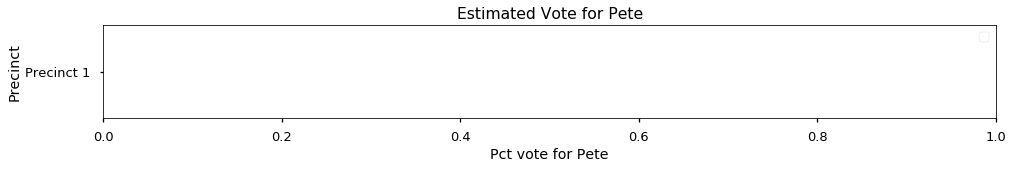

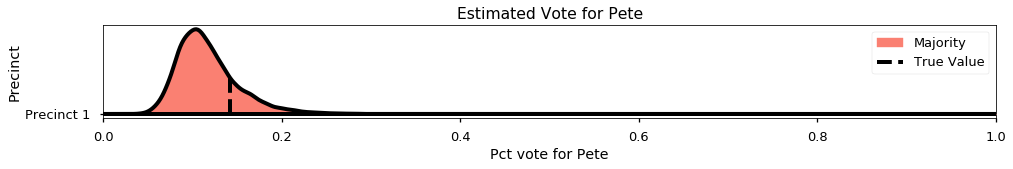

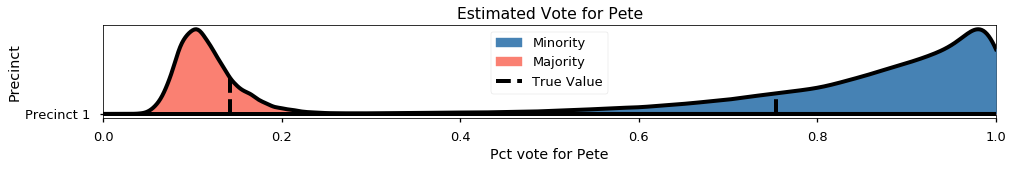

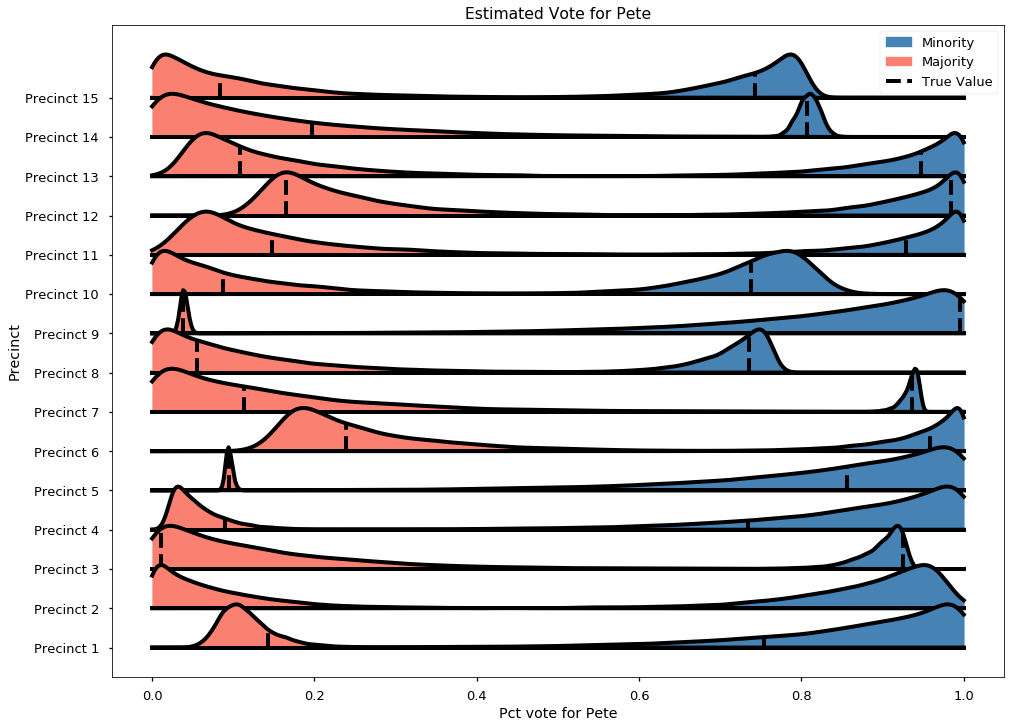

In [5]:
for step in range(4):
    print(step)
    fig, ax = make_plot(trace, minority_pct_pete, majority_pct_pete, fig_step=step);
    fig.savefig('simulated_data_{}.png'.format(step), dpi=600, transparent=True, bbox_inches='tight');